Dataset used: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In [ ]:
import pandas as pd
import numpy as np
import random
import os  

import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import sklearn.cluster as cluster

import matplotlib.pyplot as plt
plt.style.use('ggplot')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##EDA

####RAW_reviews (interactions)

In [ ]:
!gdown 1AzQNsVVG876-ntxzspL4gQtDdA633eWQ
reviews = pd.read_csv('RAW_interactions.csv')
reviews.tail()

Downloading...
From: https://drive.google.com/uc?id=1AzQNsVVG876-ntxzspL4gQtDdA633eWQ
To: /content/RAW_interactions.csv
100% 349M/349M [00:01<00:00, 201MB/s]


,user_id,recipe_id,date,rating,review
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...
1132366,2001868099,78003,2017-12-18,5,I am so glad I googled and found this here. Th...


In [ ]:
#looking for null values
reviews.isna().sum()

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64

In [ ]:
reviews.drop(['date'], axis=1, inplace=True) #drop uneccessary column
reviews = reviews.dropna(axis=0).reset_index(drop=True)  #drop rows with na (detected in review column only) and reset the index
reviews.tail()

,user_id,recipe_id,rating,review
1132193,116593,72730,0,Another approach is to start making sauce with...
1132194,583662,386618,5,These were so delicious! My husband and I tru...
1132195,157126,78003,5,WOW! Sometimes I don't take the time to rate ...
1132196,53932,78003,4,Very good! I used regular port as well. The ...
1132197,2001868099,78003,5,I am so glad I googled and found this here. Th...


In [ ]:
print("Number of unique users:", reviews['user_id'].nunique(), "\nNumber of unique recipes:", reviews['recipe_id'].nunique())

Number of unique users: 226419 
Number of unique recipes: 231630


In [ ]:
#drop users who have not done at least 10 reviews -- manually avoiding errors due to conclusions on sparse data
reviews = reviews[reviews.groupby('user_id').user_id.transform('count')>9].copy().reset_index(drop=True)
print("Total rows remaining:", len(reviews), "\n")
reviews['user_id'].value_counts()

Total rows remaining: 803334 



424680     7671
37449      5603
383346     4628
169430     4076
128473     3917
           ... 
1125280      10
1356517      10
770398       10
147960       10
302329       10
Name: user_id, Length: 12486, dtype: int64

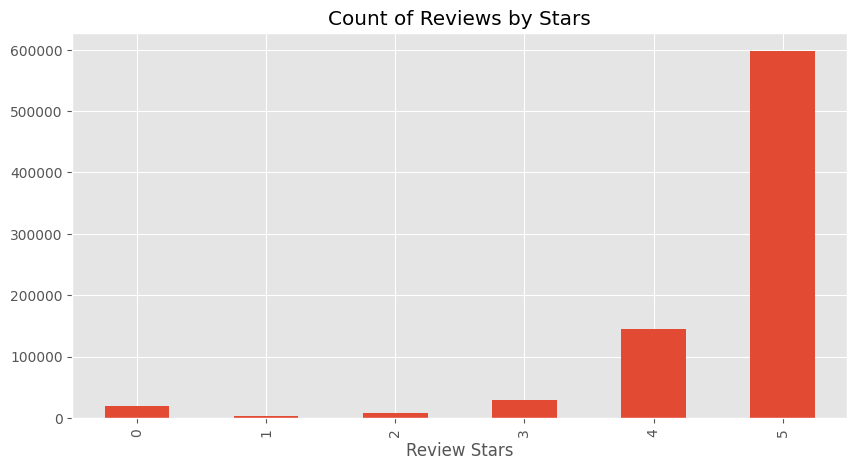

In [ ]:
#brief look at the spread of star ratings
ax = reviews['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

####RAW_recipes

In [ ]:
!gdown 1zFZQcact6jrBQ9pBQctnqiIVdauLpnDk
recipes = pd.read_csv('RAW_recipes.csv')
recipes.tail()

Downloading...
From: https://drive.google.com/uc?id=1zFZQcact6jrBQ9pBQctnqiIVdauLpnDk
To: /content/RAW_recipes.csv
100% 295M/295M [00:01<00:00, 157MB/s]


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10
231636,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",7


In [ ]:
recipes.isna().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

In [ ]:
recipes[recipes['name'].isna()]

#the null values do not seem to be in any category of significance, so we will ignore them in the cleaning process.

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
721,NaN,368257,10,779451,2009-04-27,"['15-minutes-or-less', 'time-to-make', 'course...","[1596.2, 249.0, 155.0, 0.0, 2.0, 112.0, 14.0]",6,"['in a bowl , combine ingredients except for o...",-------------,"['lemon', 'honey', 'horseradish mustard', 'gar...",10


In [ ]:
recipes = recipes[['name', 'id', 'ingredients', 'description', 'steps', 'nutrition']]  #keeping only the columns that may be of interest
recipes.tail()

,name,id,ingredients,description,steps,nutrition
231632,zydeco soup,486161,"['celery', 'onion', 'green sweet pepper', 'gar...",this is a delicious soup that i originally fou...,"['heat oil in a 4-quart dutch oven', 'add cele...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]"
231633,zydeco spice mix,493372,"['paprika', 'salt', 'garlic powder', 'onion po...",this spice mix will make your taste buds dance!,['mix all ingredients together thoroughly'],"[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]"
231634,zydeco ya ya deviled eggs,308080,"['hard-cooked eggs', 'mayonnaise', 'dijon must...","deviled eggs, cajun-style","['in a bowl , combine the mashed yolks and may...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]"
231635,cookies by design cookies on a stick,298512,"['butter', 'eagle brand condensed milk', 'ligh...","i've heard of the 'cookies by design' company,...",['place melted butter in a large mixing bowl a...,"[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]"
231636,cookies by design sugar shortbread cookies,298509,"['granulated sugar', 'shortening', 'eggs', 'fl...","i've heard of the 'cookies by design' company,...","['whip sugar and shortening in a large bowl , ...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]"


####Merge


In [ ]:
df = pd.merge(reviews, recipes, left_on="recipe_id", right_on="id")
df.drop(['id'], axis=1, inplace=True)
df.tail()

,user_id,recipe_id,rating,review,name,ingredients,description,steps,nutrition
803329,39835,249924,5,This chicken was great (skipped the bread). My...,rocky mount nc bbq chicken sandwiches,"['whole chicken', 'cider vinegar', 'crushed re...","sweet and sticky with a kick of heat, this eas...",['do this a day or two before to meld flavors:...,"[505.9, 44.0, 19.0, 18.0, 63.0, 39.0, 8.0]"
803330,496803,249924,5,I really loved this! I cut the recipe back to...,rocky mount nc bbq chicken sandwiches,"['whole chicken', 'cider vinegar', 'crushed re...","sweet and sticky with a kick of heat, this eas...",['do this a day or two before to meld flavors:...,"[505.9, 44.0, 19.0, 18.0, 63.0, 39.0, 8.0]"
803331,169430,470995,5,Just as the title promised this is a lovely sh...,perfectly fried shrimps with garlic,"['shrimp', 'garlic cloves', 'olive oil']",succulent shrimps fried in olive oil with cara...,"['preparation', 'rinse the shrimps with cold w...","[397.0, 62.0, 0.0, 8.0, 10.0, 28.0, 1.0]"
803332,648540,241491,5,"Fabulous! We are vegetarian, so I used vegetar...",maple apple baked beans,"['dried navy beans', 'water', 'bacon', 'onion'...",i've been looking for a perfect baked bean rec...,"['place beans in soup kettle', 'add water to c...","[518.1, 29.0, 138.0, 26.0, 34.0, 35.0, 24.0]"
803333,1269180,257796,4,Very tender and juicy - had trouble getting t...,slow cooker garlic chicken with rosemary,"['roasting chickens', 'lemons', 'rosemary spri...",delicious and easy!,"['place rosemary springs , 1 lemon half , cele...","[566.2, 59.0, 12.0, 15.0, 86.0, 55.0, 3.0]"


In [ ]:
print("reviews:",len(df), "\nusers:", df['user_id'].nunique(), "\nrecipes:", df['recipe_id'].nunique()) 

reviews: 803334 
users: 12486 
recipes: 204930


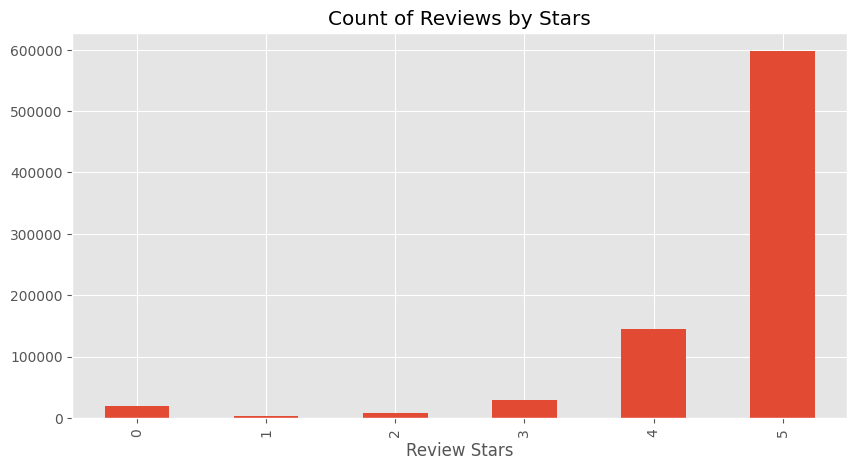

In [ ]:
#brief look at the spread of star ratings
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

##Sentiment analysis

In [ ]:
def Sentiments_Analysis(df2, path='', retrieve=False):
  if retrieve:
    #download the file saved from a prior run
    !gdown 1UqDY_Mtc92ihfSQcLZP5utc8OM_IcJi1
    df2 = pd.read_csv('data_postSentimentAnalysis.csv')
    df2.drop("Unnamed: 0", axis=1, inplace=True) 
  
  else:
    #getting the sentiment analysis scores for all reviews
    sia = SentimentIntensityAnalyzer()
    df2['vader_compound'] = df2['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

    #attempting to save file so that it can be loaded next time
    if not os.path.exists(path):
      print("File not saved. Invalid path.")
    else:
      df2.to_csv(path+'data_postSentimentAnalysis.csv')  

  return df2


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# #specify file location in which to save file --use if you want
path = ''
# path = '/content/drive/MyDrive/S23 Information Retrieval/IR Project/' 

df = Sentiments_Analysis(df, path, False)  #if third input is True, it will fetch a previously saved file, else it will find and attach vader score
df.tail()

Downloading...
From: https://drive.google.com/uc?id=1UqDY_Mtc92ihfSQcLZP5utc8OM_IcJi1
To: /content/data_postSentimentAnalysis.csv
100% 1.04G/1.04G [00:05<00:00, 190MB/s]


,user_id,recipe_id,rating,review,name,ingredients,description,steps,nutrition,vader_compound
803329,39835,249924,5,This chicken was great (skipped the bread). My...,rocky mount nc bbq chicken sandwiches,"['whole chicken', 'cider vinegar', 'crushed re...","sweet and sticky with a kick of heat, this eas...",['do this a day or two before to meld flavors:...,"[505.9, 44.0, 19.0, 18.0, 63.0, 39.0, 8.0]",0.8856
803330,496803,249924,5,I really loved this! I cut the recipe back to...,rocky mount nc bbq chicken sandwiches,"['whole chicken', 'cider vinegar', 'crushed re...","sweet and sticky with a kick of heat, this eas...",['do this a day or two before to meld flavors:...,"[505.9, 44.0, 19.0, 18.0, 63.0, 39.0, 8.0]",0.9363
803331,169430,470995,5,Just as the title promised this is a lovely sh...,perfectly fried shrimps with garlic,"['shrimp', 'garlic cloves', 'olive oil']",succulent shrimps fried in olive oil with cara...,"['preparation', 'rinse the shrimps with cold w...","[397.0, 62.0, 0.0, 8.0, 10.0, 28.0, 1.0]",0.8481
803332,648540,241491,5,"Fabulous! We are vegetarian, so I used vegetar...",maple apple baked beans,"['dried navy beans', 'water', 'bacon', 'onion'...",i've been looking for a perfect baked bean rec...,"['place beans in soup kettle', 'add water to c...","[518.1, 29.0, 138.0, 26.0, 34.0, 35.0, 24.0]",0.8497
803333,1269180,257796,4,Very tender and juicy - had trouble getting t...,slow cooker garlic chicken with rosemary,"['roasting chickens', 'lemons', 'rosemary spri...",delicious and easy!,"['place rosemary springs , 1 lemon half , cele...","[566.2, 59.0, 12.0, 15.0, 86.0, 55.0, 3.0]",0.8528


####Anayzing special cases where the rating is 0. 
(Sentiments derived from the corresponding reviews might not be accounted to the recipes, since this rating is not really a 'Rating', but a stand in for a refusal to rate.) 

There are several options in how to deal with this. Currently it is set to just delete all rows of data with a rating of 0.

In [ ]:
df0 = df[df["rating"]==0]
df0.tail()

,user_id,recipe_id,rating,review,name,ingredients,description,steps,nutrition,vader_compound
803061,374506,39724,0,Great!!! After the turkey was done I browned t...,seasoned crock pot turkey breast,"['turkey breast', 'fresh garlic', 'marjoram', ...","a tender, juicy method for cooking a turkey. t...","['wash turkey , drain , and place in 3-1 / 2 q...","[405.8, 27.0, 5.0, 9.0, 109.0, 23.0, 1.0]",0.8464
803100,51224,287006,0,This is the recipe that is all over the intern...,jalapeno cheese soup,"['chicken broth', 'celery', 'yellow onions', '...",a nice soup for cold winter days. you can adju...,"['cut the velveeta cheese into cubes', 'in a l...","[784.9, 79.0, 97.0, 190.0, 90.0, 164.0, 11.0]",0.5719
803123,811179,136702,0,We made our gluten-free with GF flour and it w...,english sticky toffee pudding,"['butter', 'dark brown sugar', 'egg', 'all-pur...",this recipe was given to me by an english cowo...,"['directions for pudding:', 'preheat oven to 3...","[434.0, 30.0, 195.0, 10.0, 6.0, 61.0, 21.0]",-0.4466
803219,102526,54493,0,I am not going to rate this because I did have...,garlic clove chicken,"['chicken', 'garlic', 'dry white wine', 'lemon...","garlic and chicken what could be better, the c...","['preheat oven to 325 degrees', 'spray a large...","[338.3, 32.0, 1.0, 7.0, 53.0, 29.0, 2.0]",-0.5075
803294,176615,118119,0,We've tried lots of peanut butter pasta recipe...,peanut butter spirals,"['peanut butter', 'vegetable stock', 'soy sauc...",my kids like this one and i was really surprised.,['add the first 7 ingredients to a blender or ...,"[347.6, 18.0, 31.0, 26.0, 28.0, 11.0, 16.0]",0.8478


There are a total of  19052 reviews with a rating of 0. 
The graph shows the spread of their sentiment analysis scores, attained by the corresponding review.


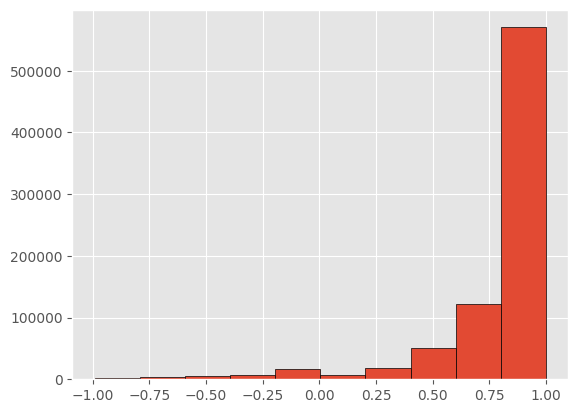

In [ ]:
print("There are a total of ", len(df0), "reviews with a rating of 0.",
      "\nThe graph shows the spread of their sentiment analysis scores, attained by the corresponding review.")
n, bins, patches = plt.hist(df["vader_compound"], edgecolor='black')
plt.show()

In [ ]:
print("\n\nNote that a rating of zero does not always mean a negative review.",
      "\nExamples of notably positive review with rating of 0:", df0[df0['vader_compound']>0.9]['review'][:10])



Note that a rating of zero does not always mean a negative review. 
Examples of notably positive review with rating of 0: 516     This soup was delicious. i only made a couple ...
838     I am not going to rate this, since I had to ma...
862     Easy and delicious. I cooked my eggs 20 minute...
882     Yum! I made these for a church bake sale. They...
1516    Excellent pico!  I have realized I do not like...
1859    I made this exactly as written, using Ghiradel...
2327    I think the key is go spread these out on a co...
2557    I had really high hopes for this dish, but it ...
2638    Delicious and moist and fudgey!  I used white ...
2639    DIVINE!  I have made this a couple of times no...
Name: review, dtype: object


In [ ]:
print("There are cases where users deliberately left at a rating of 0:\n\n", df0['review'][838], '\n\n', df0['review'][77199],
      "\n\n\nIn other cases the user seems to have forgotten to give a rating alongside the review:\n\n", df0['review'][2557], '\n\n', df0['review'][2639],
      "\n\n\nWe aim to ommit the former as the sentiments analyzed from the corresponding review *might* not be aimed at the recipe.")

There are cases where users deliberately left at a rating of 0:

 I am not going to rate this, since I had to make quite a few changes, but what I did was delicious.  First of all I used the ground chorizo, since it was what I had.  I did not have garlic cloves, so I used garlic powder.  I used a can of undrained diced tomatoes and in place of the red wine, I used beef broth.  It was very good having made these changes, even my 2 yo really liked it.  I will make it again.  Maybe I will be able to make it the way it is written! 

 I chose not to rate this recipe as I modified it to suit what we had in the fridge...didn't have enough mayo so I used half mayo and half sour cream for the sauce--turned out wonderfully that way, I think sour cream was a good sub. 
(made some other subs not worth mentioning..)
My other comment is that these crisped up even more when re-heated under the broiler the next day!  Thank you for posting: great flavor, and I will plan to have enough mayo on hand the 

Options (for ratings of 0):

1.   Keep as is.
2.   Remove all reviews (rows) with intentional ratings of 0.
     >Issue is finding which one is intentional. A rudimentary method is used below. There may be low accuracy in pinpointing intentional vs not, but we may implement this method for this project. 
3. Remove all reviews with ratings of 0.

We will do option 3 in our implementation --there are enough recipes to afford this.

######Option 2:
This does not need to be commented out for option 3 to work, but does for option 1.

In [ ]:
remove = []
for i, row in df0.iterrows():
  if 'rate' in row['review'].split(" ") or 'rated' in row['review'].split(" ") or 'rating' in row['review'].split(" "):
    remove.append(i)
len(remove)

1926

In [ ]:
#seeing some of those detected by the rudimentary rule used --some detections are correct while others are not. Those not detected at all cannot be captured using this method.
i=random.choice(remove)
print("Index", i, '\n\n', df0['review'][i], '\n\n', df0['vader_compound'][i])

Index 141793 

 I didn't want to rate as I made quite a few changes, but wow, was it good!  Even my kids liked it.  I used 1 lb ground beef 1 lb ground turkey.  Added dried minced onions, wheat bran and flax meal, plus a little oatmeal.  Used turkey slices and put Swiss slices in with teh turkey slices.  Topped with brown sugar and mustard mixture.  Yum! 

 0.9351


In [ ]:
df = df.drop(remove)#.reset_index(drop=True)
len(df)

801408

(array([  4857.,  11969.,  24495.,  68736., 691351.]),
 array([-0.99   , -0.59212, -0.19424,  0.20364,  0.60152,  0.9994 ]),
 <BarContainer object of 5 artists>)

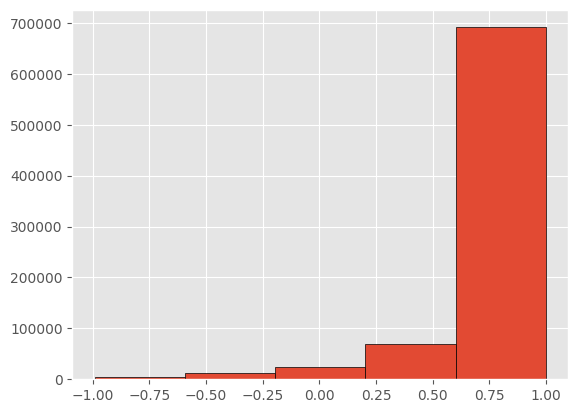

In [ ]:
#look at changes to vader_compound score spread with this (option 2) removal
plt.hist(df["vader_compound"], bins=5, edgecolor='black')

######Option 3:
Must be commented out for options 1 or 2.

In [ ]:
len(df)

801408

In [ ]:
df = df.loc[df['rating'] != 0].reset_index(drop=True)
len(df)

784282

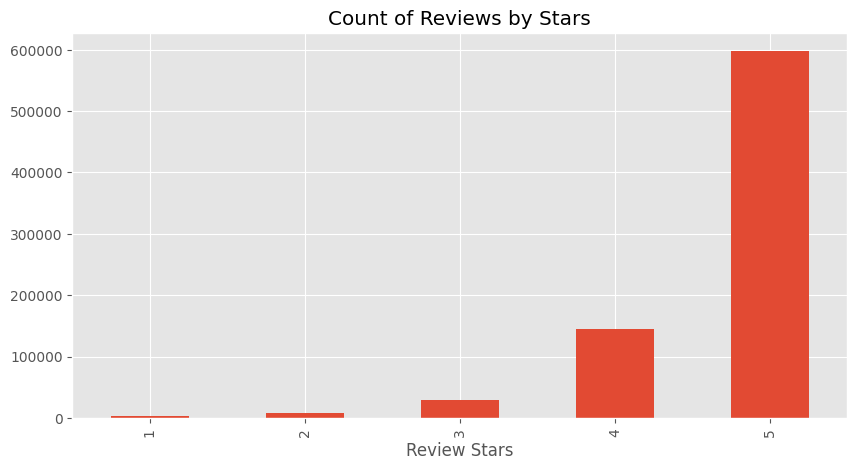

In [ ]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

(array([  4369.,  11112.,  22710.,  66068., 680023.]),
 array([-0.99   , -0.59212, -0.19424,  0.20364,  0.60152,  0.9994 ]),
 <BarContainer object of 5 artists>)

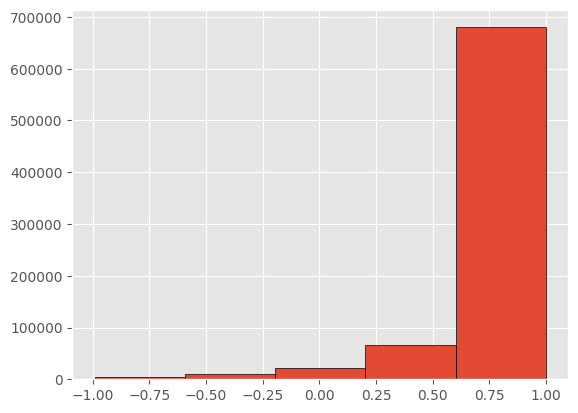

In [ ]:
plt.hist(df["vader_compound"], bins=5, edgecolor='black')


##Clustering

In [ ]:
#considering the imbalances and the nature of the task (unsupervised), this might not be the best method of evaluation

#if testing set required
# train2, test = train_test_split(df, df['user_id'], test_size=0.3, random_state=42)[:2]  #split for training on KMeans and for testing
# train1 = train_test_split(train2, train2['user_id'], test_size=0.05, random_state=42)[1]  #subsplit for training KNN

train1 = train_test_split(df, df['user_id'], test_size=0.04, random_state=42)[1]  #split for training on KMeans and for testing
train2 = df

In [ ]:
print(len(train1), len(train2))

31372 784282


####KNN clustering ('cluster1')

In [ ]:
# do user clustering based on past reviews using KNN
vectorizer = TfidfVectorizer(stop_words='english')
df_review = vectorizer.fit_transform(train1['review'])
knn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')
knn.fit(df_review)
distances, indices = knn.kneighbors(df_review)
train1['cluster1'] = indices[:, 1]

train1.tail()

,user_id,recipe_id,rating,review,name,ingredients,description,steps,nutrition,vader_compound,cluster1
747270,344231,215169,5,WOW!!! In a word...WOW!!! These taste exactly ...,red lobster cheddar bay biscuits,"['biscuit mix', 'buttermilk', 'cheddar cheese'...",these taste just like the ones that red lobste...,"['preheat oven to 450 degrees f', 'mix biscuit...","[536.1, 57.0, 37.0, 44.0, 20.0, 100.0, 13.0]",0.9813,12176
504346,107554,99949,5,We make these at our house quite often and lov...,ham and cream cheese rollups,"['deli ham', 'cream cheese', 'green onions']","a few years a go, an employee of mine brought ...","['mix cream cheese with onion', 'spread on ham...","[29.4, 3.0, 0.0, 3.0, 2.0, 7.0, 0.0]",0.6666,24151
570931,25356,14645,4,This was very good but it had a little too muc...,chicken fettuccine with 4 kinds of cheese,"['fettuccine', 'cream of mushroom soup', 'crea...",this is a wonderful creamy mixture that is a m...,"['cook fettuccine by directions on package', '...","[652.1, 75.0, 11.0, 36.0, 48.0, 104.0, 9.0]",0.7838,29890
80831,422893,137970,4,I don't know what a S'more is but these were l...,s mores muffins,"['all-purpose flour', 'graham cracker crumbs',...",my kids love these muffins. the reviewers are ...,"['in a bowl , whisk the flour and next 5 ingre...","[205.2, 13.0, 61.0, 13.0, 7.0, 25.0, 9.0]",0.9020,17833
187082,517198,97731,4,This was pretty good...our meat was still a li...,rub tenderizer for london broil,"['london broil beef', 'fresh cracked pepper', ...",this rub makes the meat melt and explode in yo...,"['score meat in diagonal , criss-cross pattern...","[286.5, 21.0, 4.0, 3.0, 72.0, 26.0, 0.0]",0.4522,18202


####K-means clustering ('cluster2')
https://www.youtube.com/watch?v=3Spa10-mwsw

In [ ]:
kmeans = cluster.KMeans(n_clusters=50, init='k-means++')  #number of clusters have been arbritrarily set to 50.
kmeans = kmeans.fit(train2[['user_id', 'recipe_id', 'vader_compound']])

train2['cluster2'] = kmeans.labels_

train2.tail()

,user_id,recipe_id,rating,review,name,ingredients,description,steps,nutrition,vader_compound,cluster2
784277,39835,249924,5,This chicken was great (skipped the bread). My...,rocky mount nc bbq chicken sandwiches,"['whole chicken', 'cider vinegar', 'crushed re...","sweet and sticky with a kick of heat, this eas...",['do this a day or two before to meld flavors:...,"[505.9, 44.0, 19.0, 18.0, 63.0, 39.0, 8.0]",0.8856,46
784278,496803,249924,5,I really loved this! I cut the recipe back to...,rocky mount nc bbq chicken sandwiches,"['whole chicken', 'cider vinegar', 'crushed re...","sweet and sticky with a kick of heat, this eas...",['do this a day or two before to meld flavors:...,"[505.9, 44.0, 19.0, 18.0, 63.0, 39.0, 8.0]",0.9363,12
784279,169430,470995,5,Just as the title promised this is a lovely sh...,perfectly fried shrimps with garlic,"['shrimp', 'garlic cloves', 'olive oil']",succulent shrimps fried in olive oil with cara...,"['preparation', 'rinse the shrimps with cold w...","[397.0, 62.0, 0.0, 8.0, 10.0, 28.0, 1.0]",0.8481,48
784280,648540,241491,5,"Fabulous! We are vegetarian, so I used vegetar...",maple apple baked beans,"['dried navy beans', 'water', 'bacon', 'onion'...",i've been looking for a perfect baked bean rec...,"['place beans in soup kettle', 'add water to c...","[518.1, 29.0, 138.0, 26.0, 34.0, 35.0, 24.0]",0.8497,35
784281,1269180,257796,4,Very tender and juicy - had trouble getting t...,slow cooker garlic chicken with rosemary,"['roasting chickens', 'lemons', 'rosemary spri...",delicious and easy!,"['place rosemary springs , 1 lemon half , cele...","[566.2, 59.0, 12.0, 15.0, 86.0, 55.0, 3.0]",0.8528,49


In [ ]:
#we see that each review (row) gets a cluster assignment, but...
print(len(train2), train2['cluster2'].value_counts().sum())

784282 784282


In [ ]:
#...though a single user can belong to multiple clusters, 
#there are distinctions, as seen here. This user centers 
#around seven clusters
train2[train2['user_id']==128473]['cluster2'].value_counts()


21    1097
48     950
27     691
17     506
28     434
46     234
Name: cluster2, dtype: int64

In [ ]:
train2['user_id'].value_counts()

424680     7665
37449      5497
383346     4602
169430     4008
128473     3912
           ... 
815670        2
142053        1
2166500       1
713301        1
165217        1
Name: user_id, Length: 12481, dtype: int64

In [ ]:
#checks how the cluster shows up for a random user
user = reviews.user_id.unique()[random.randrange(len(reviews.user_id.unique()))]
user_clusters = set(train2[train2['user_id']==user]['cluster2'].values)
print("User ID", user, "belong to the clusters:", user_clusters, 
      "\nThis user has submitted", sum(train2['user_id']==user), "reviews to the subset of data being analyzed.")

#see data of all reviews/users that fall into that cluster
print("\nThe following table shows data from all users/reviews in at least one of these clusters:")
train2[train2.cluster2.isin(user_clusters) == True]

User ID 250063 belong to the clusters: {0, 8, 36, 45} 
This user has submitted 12 reviews to the subset of data being analyzed.

The following table shows data from all users/reviews in at least one of these clusters:


,user_id,recipe_id,rating,review,name,ingredients,description,steps,nutrition,vader_compound,cluster2
7,255338,134728,5,First time using liquid smoke in a recipe. Mad...,kfc honey bbq strips,"['chicken tenders', 'flour', 'garlic powder', ...",these are so yummy and they do taste just like...,"['mix flour , salt and pepper in bowl', 'set a...","[316.0, 4.0, 40.0, 37.0, 78.0, 4.0, 10.0]",0.7003,36
15,224088,254596,4,Pork + fruit + crockpot = awesome.\n\nA very g...,apple apricot pork chops crock pot,"['pork chops', 'apple', 'dried apricot', 'cran...","i'm not sure where i got this recipe, but it's...","['combine all ingredients', 'cover and cook 7 ...","[710.0, 44.0, 210.0, 7.0, 94.0, 50.0, 21.0]",0.9754,8
19,183565,79222,5,Wow! My family loves this recipe and it is a ...,potato crab chowder,"['butter', 'onion', 'garlic', 'potatoes', 'flo...",soup for the soul!,['saute onion& garlic in melted butter in larg...,"[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",0.9436,0
22,226989,79222,4,DH and I enjoyed this. However I used it only ...,potato crab chowder,"['butter', 'onion', 'garlic', 'potatoes', 'flo...",soup for the soul!,['saute onion& garlic in melted butter in larg...,"[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",0.7830,0
25,241697,79222,5,Really great recipe!! Although I did not have ...,potato crab chowder,"['butter', 'onion', 'garlic', 'potatoes', 'flo...",soup for the soul!,['saute onion& garlic in melted butter in larg...,"[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",0.8643,0
...,...,...,...,...,...,...,...,...,...,...,...
784240,195750,56509,2,Chicken turned out pretty good but the sauce w...,chicken with peach champagne sauce,"['boneless skinless chicken breasts', 'fresh l...",this is a recipe that i haven't tried from eme...,['sprinkle chicken with lemon juice and pepper...,"[482.0, 22.0, 37.0, 12.0, 112.0, 13.0, 6.0]",0.4678,0
784247,227652,326158,5,Great recipe. I needed a good recipe for rolls...,whole wheat herb rolls,"['warm water', 'active dry yeast', 'sugar', 'b...",the original recipe is from breadworld.com. so...,"['dissolve yeast in 1 / 4 cup warm water', 'ad...","[78.9, 3.0, 8.0, 4.0, 4.0, 6.0, 4.0]",0.9512,8
784248,229052,253419,5,"I used 15 ounces of peanut butter, left out th...",flourless peanut butter oatmeal cookies,"['peanut butter', 'butter', 'quick oats', 'egg...",i saw this recipe in toh and changed a few thi...,"['preheat oven to 350', 'cream butter , peanut...","[173.7, 13.0, 57.0, 4.0, 8.0, 17.0, 6.0]",0.7906,8
784252,207616,40514,5,A quick and easy lunch for me using little bit...,sun dried tomato bruschetta with goat cheese,"['goat cheese', 'italian bread', 'sun-dried to...",these are good. if you haven't tried goat chee...,"['preheat broiler', 'slice your bread , if you...","[94.6, 5.0, 4.0, 8.0, 8.0, 10.0, 3.0]",0.9229,0


##Filtering by ingredients

In [ ]:
# filter recipes using ingredients passed -- given a list of ingredients this will go through and find recipes that contain all of those ingredients
def filter_recipes(ingredients):
  recipes_df_copy = df.copy()
  recipes = recipes_df_copy[recipes_df_copy['ingredients'].apply(lambda x: all(i.lower() in x.lower() for i in ingredients))]
  return recipes

In [ ]:
# get the plausible recipes
def plausible_recipes(ingredients, df):
    recipes = filter_recipes(ingredients)

    # if fewer than 5 plausible recipes returned, add common ingredients to get more plausible recipes
    if len(recipes) < 5:
        common_ingredients = []
        for dx, row in df[df['recipe_id'].isin(recipes['recipe_id'])].iterrows():
            common_ingredients.extend([i.lower() for i in row['ingredients'].split(',')])
        common_ingredients = [i for i in set(common_ingredients) if i not in [i.lower() for i in ingredients]]
    
        if len(common_ingredients) > 0:
            added_ingredients = ingredients + common_ingredients
            recipes = filter_recipes(added_ingredients)
    
    # check the length to return the results 
    if len(recipes) == 0:    
      # if it is empty, return empty
      return []   
    # elif len(recipes) < 100:    
    #   # if recipes list is less than 10 return the available number
    #   return recipes.sort_values('rating', ascending=False).head(len(recipes))
    else:
      # if its greater than 10 return the top 100
      return recipes.sort_values('rating', ascending=False).head(len(recipes)).head(len(recipes))#.head(100)


In [ ]:
# #sample run for testing

# user=128473
# clusters = train2[train2['user_id']==user]['cluster2'].value_counts().index.to_list()  #clusters of roleplayed user
# users_in_clusters = set(train2[train2['cluster2'].isin(clusters)]['user_id'])  #other users of same cluster

# new_df = train2[train2['user_id'].isin(users_in_clusters)]  #get reviews by users within the cluster
# recipes_scores = new_df.groupby('recipe_id')['vader_compound'].mean().reset_index()
# recipes_scores = recipes_scores.sort_values(by=['vader_compound'], ascending=False).reset_index().drop('index', axis=1)

# print(len(recipes_scores.recipe_id),recipes_scores['recipe_id'].nunique())
# recipes_scores

In [ ]:
import warnings

warnings.filterwarnings("ignore")

# Rank recipes based on user cluster sentiment scores
def rank_recipes(ingredients, user=128473):
   
  #For KNN:

    recipes = plausible_recipes(ingredients, train1)
    if len(recipes) == 0:
      return []

    # get unique recipes ids from the returned plausible recipes
    rids = list(set(recipes['recipe_id']))
    new_df = train1[train1['recipe_id'].isin(rids)]

    # group new df by recipe_id and calculate mean sentiment score
    recipes_scores = new_df.groupby('cluster1')['vader_compound'].mean().reset_index()

    # sort recipes within each cluster by sentiment score in descending order
    recipes_scores = new_df.groupby('recipe_id').apply(lambda x: x.sort_values('vader_compound', ascending=False))   ##changed from cluster1 to recipe_id

    # extract recipe IDs and convert to list
    ranked_recipes = recipes_scores['recipe_id'].tolist()

    # remove duplicates
    ranked_recipes1 = list(set(ranked_recipes))
    


  #For K-means

    recipes = plausible_recipes(ingredients, train2)
    if len(recipes) == 0:
      return []

    # get unique recipes ids from the returned plausible recipes
    rids = list(set(recipes['recipe_id']))

    #find users in the same cluster
    clusters = train2[train2['user_id']==user]['cluster2'].value_counts().index.to_list()  #clusters of roleplayed user
    users_in_clusters = set(train2[train2['cluster2'].isin(clusters)]['user_id'])  #other users of same cluster

    if len(users_in_clusters) > 30:
      # print("yes")
      new_df = train2[(train2['recipe_id'].isin(rids)) & (train2['user_id'].isin(users_in_clusters))]  #get reviews by users within the cluster
      recipes_scores = new_df.groupby('recipe_id')['vader_compound'].mean().reset_index()  #finds mean vader score for each recipe
      recipes_scores = recipes_scores.sort_values(by=['vader_compound'], ascending=False).reset_index().drop('index', axis=1)  #sorts recipe by order of vader score
    else:
      # print("no")
      new_df = train2[train2['recipe_id'].isin(rids)]  #gets all reviews of possible recipes
      new_df['vader_compound'] = new_df['vader_compound']/((2-train2.user_id.isin(users_in_clusters).astype(int))**3) #lowers intensity of sentiments of users outside of the clust by a factor of 8
      recipes_scores = new_df.groupby('recipe_id')['vader_compound'].mean().reset_index()  #finds mean vader score for each recipe
      recipes_scores = recipes_scores.sort_values(by=['vader_compound'], ascending=False).reset_index().drop('index', axis=1)  #sorts recipe by order of vader score

      # recipes_scores = new_df.groupby('cluster2').apply(lambda x: x.sort_values('vader_compound', ascending=False)) #uses vader score to 

    # extract recipe IDs and convert to list
    ranked_recipes = recipes_scores['recipe_id'].tolist()

    # remove duplicates
    ranked_recipes2 = list(set(ranked_recipes))



    if len(ranked_recipes1) > 10:
      ranked_recipes1 = ranked_recipes1[:10]  
    if len(ranked_recipes2) > 10:
      ranked_recipes2 = ranked_recipes2[:10] 
    
    return ranked_recipes1, ranked_recipes2 

In [ ]:
# user interface to enter ingredients and display top recommendations

def run_recommendation(ingredients, user=128473):
  ranked_results1, ranked_results2 = rank_recipes(ingredients, user)

  for ranked_results in [ranked_results1, ranked_results2]:
    if ranked_results == ranked_results1:
        print("\n\nResults using KNN for clustering (on a smaller subset of the cleaned dataset):")
    else:
        print("\n\nResults using KMeans for clustering (on the cleaned dataset):")
        
    if len(ranked_results) == 0:
        print('No plausible recipes found.')
    else:
        print(f'Top {len(ranked_results)} recipe recommendations:')
        for n, rid in enumerate(ranked_results):
            rname = df[df['recipe_id'] == rid]['name'].iloc[0]
            print(f'{n+1}. {rname}')

In [ ]:
ingredients = input('Enter ingredients (use comma`,` to separate: ').split(',')
run_recommendation(ingredients, user=1329782)

Enter ingredients (use comma`,` to separate: rice noodle


Results using KNN for clustering (on a smaller subset of the cleaned dataset):
Top 10 recipe recommendations:
1. sea scallops
2. thai noodles  pad thai
3. tofu pad thai
4. vietnamese rice noodle salad with grilled tofu
5. thai rice noodles
6. asian meatballs with rice noodles
7. thai noodles with chicken patties  soup or salad
8. pad thai salad
9. thai stir fried wide rice noodles   pad si iew
10. colorful thai style noodles


Results using KMeans for clustering (on the cleaned dataset):
Top 10 recipe recommendations:
1. singapore mai fun
2. easy thai chicken noodle soup
3. copycat p f  chang s singapore street noodles
4. thai noodles  pad thai
5. rice noodles with thai basil  mint and peanuts
6. edamame lo mein
7. tofu pad thai
8. vegetarian pho  crock pot
9. bangkok style chicken pad thai
10. pad thai with chicken and shrimp
